In [1]:
import netCDF4 as nc
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# 加载数据--feature
with open('../data_target_01/target_model.pkl', 'rb') as f:
    dataset_feature = pickle.load(f)
print(dataset_feature.keys())

dict_keys(['uwnd', 'vwnd', 'temp', 'hght', 'rhum', 'lspe', 'sstk', 't2mm', 'u10m', 'v10m', 'visi', 't2md', 'cape', 'velocity10m', 'degree10m'])


In [3]:
# 加载数据--label
with open('../data_target_01/target_observation.pkl', 'rb') as f:
    real_target = pickle.load(f)
print(real_target.keys())

dict_keys(['velocity', 'degree', 'temp', 'rain'])


In [4]:
# 时间
with open('../data_target_01/target_time_axis.pkl', 'rb') as f:
    axis = pickle.load(f)
real_time = axis.to_numpy().reshape(-1,1)

In [5]:
real_time.shape

(2680, 1)

In [6]:
label_velocity = real_target['velocity'].reshape((-1,1))
label_temp = real_target['temp'].reshape((-1,1))

In [7]:
# 提取数据 ###########################################
temp = dataset_feature['temp']
t2md = dataset_feature['t2md']

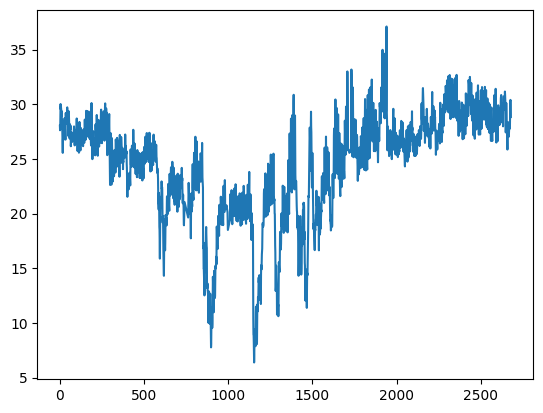

In [8]:
plt.plot(temp)

In [8]:
##########################################
feature = np.column_stack((temp, t2md))
feature.shape

(2680, 2)

In [9]:
# 归一化参数
feature_min = np.min(feature, axis=0)
feature_max = np.max(feature, axis=0)
# 归一化
feature = (feature - feature_min) / (feature_max - feature_min)

In [10]:
# 数据集构建函数
def create_feature_label(feature_seq, label_seq, time_seq, seq_len, ahead_day):
    # 待处理特征片段 和 构建标签
    if ahead_day == 0:
        x = feature_seq
        t = time_seq[seq_len - 1:, :]
    else:
        x = feature_seq[0: -ahead_day, :]
        t = time_seq[seq_len - 1: -ahead_day, :]
    y = label_seq[seq_len + ahead_day - 1:, :]
    
    # 计算样本量
    B, V = feature_seq.shape
    sample_num = B - seq_len - ahead_day + 1
    # 构建容器
    feature, label = np.empty((sample_num, seq_len, V)), np.empty((sample_num, 1))
    time_axis = np.empty((sample_num, 1))
    # 循环写入
    for i in range(sample_num):
        feature[i, :, :] = x[i: i + seq_len, :]
        label[i] = y[i, :]
        time_axis[i] = t[i, :]
    return feature, label, time_axis

In [11]:
# 构建 特征 和 标签 ###################################
feature, label, time_axis = create_feature_label(feature, label_temp, real_time, 
                                                 seq_len=8 * 30 *3, ahead_day=0)

In [12]:
print(feature.shape, label.shape, time_axis.shape)

(1961, 720, 2) (1961, 1) (1961, 1)


In [13]:
sample_num = feature.shape[0]

In [14]:
# 训练数据转为tensor对象
feature_target = torch.from_numpy(feature).to(torch.float32)
label_target = torch.from_numpy(label).to(torch.float32)

In [15]:
feature_target.shape

torch.Size([1961, 720, 2])

In [16]:
label_target.shape

torch.Size([1961, 1])

In [17]:
time_axis.shape

(1961, 1)

In [18]:
# 划分数据集
feature_train = feature_target[:round(0.7*sample_num),:]
label_train = label_target[:round(0.7*sample_num),:]
time_train = time_axis[:round(0.7*sample_num)]

feature_val = feature_target[round(0.7*sample_num):round(0.8*sample_num),:]
label_val = label_target[round(0.7*sample_num):round(0.8*sample_num),:]
time_val = time_axis[round(0.7*sample_num):round(0.8*sample_num)]

feature_test = feature_target[round(0.8*sample_num):,:]
label_test = label_target[round(0.8*sample_num):,:]
time_test = time_axis[round(0.8*sample_num):]

In [19]:
print(feature_train.shape, label_train.shape, feature_val.shape, label_val.shape, feature_test.shape, label_test.shape)

torch.Size([1373, 720, 2]) torch.Size([1373, 1]) torch.Size([196, 720, 2]) torch.Size([196, 1]) torch.Size([392, 720, 2]) torch.Size([392, 1])


In [20]:
# 保存 训练 和 测试 数据集
parameter_dict_norm = {'feature_min': feature_min, 'feature_max': feature_max}
data_dict_train = {'feature_train': feature_train.numpy(),
                   'label_train': label_train.numpy(),
                   'time_train': time_train}
data_dict_test = {'feature_test': feature_test.numpy(),
                   'label_test': label_test.numpy(),
                   'time_test': time_test}

################################################
sio.savemat('../data_model_target_01/LSTM_temp/parameter_norm_lstm.mat', parameter_dict_norm)
sio.savemat('../data_model_target_01/LSTM_temp/dataset_train_lstm.mat', data_dict_train)
sio.savemat('../data_model_target_01//LSTM_temp/dataset_test_lstm.mat', data_dict_test)

In [21]:
# 构建一个LSTM模型
class MyLSTM(nn.Module):
    """
    
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        
        """
        # 继承父类的初始化方法
        super(MyLSTM, self).__init__()
        # 定义类属性
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        # 定义模型
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [22]:
# 编写训练逻辑

def training_loop(n_epochs, optimizer, model, loss_fn, feature_train, label_train, feature_val, label_val):
    """
    
    """
    # 选择模型
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    # 移动到device上运算
    model.to(device)
    feature_train = feature_train.to(device)
    label_train = label_train.to(device)
    feature_val = feature_val.to(device)
    label_val = label_val.to(device)
    
    # 初始化上一轮的loss_train
    loss_train_previous = 0
    for epoch in range(1, n_epochs + 1):
        
        predict_train = model(feature_train)
        loss_train = loss_fn(predict_train, label_train)

        optimizer.zero_grad()
        loss_train.backward()

        optimizer.step()
            
        with torch.no_grad():
                predict_val= model(feature_val)
                loss_val = loss_fn(predict_val, label_val)
                
        if epoch % 200 == 0:
            print('Epoch: %d, \t Loss_train: %f, \t Loss_val: %f' % (epoch, float(loss_train), float(loss_val)))
            
        # loss_train不再变化时跳出循环
#         print(loss_train, loss_train_previous)
        if loss_train - loss_train_previous == 0:
            break
        
        # 更新loss_train_previous
        loss_train_previous = loss_train

In [23]:
# 定义训练参数
#############################
repeat = 2
num_layers = range(1, 3 + 1, 1)
hidden_sizes = range(20, 100 + 20, 20)
input_size = 2
output_size = 1

In [24]:
# 保存训练参数--遍历结构所用参数
find_struction_parameter_dict = {'repeat': repeat, 'num_layerss': num_layers,
                                'hidden_sizes': hidden_sizes}
#######################################
sio.savemat('../data_model_target_01/LSTM_temp/find_struction_parameter_lstm.mat', find_struction_parameter_dict)

In [25]:
# 创建度量存储数组
rmse_arr = np.empty((repeat, len(num_layers), len(hidden_sizes)))
corrcoef_arr = np.empty((repeat, len(num_layers), len(hidden_sizes)))

In [26]:
model_dir = r'../model_target_01/LSTM_temp/'

In [27]:
import time
# 开始时间戳
start_time = time.time()
# 循环训练
for i, loop in enumerate(range(repeat)):
    for j, num_layer in enumerate(num_layers):
        for k, hidden_size in enumerate(hidden_sizes):
            # 定义模型
            model = MyLSTM(input_size, hidden_size, num_layer, output_size)
            # 训练次数
            n_epochs = 2000
            # 优化器
            optimizer = optim.Adam(model.parameters(), lr=1e-2)
            # 损失函数
            loss_fn = nn.MSELoss()
            # 训练模型
            training_loop(n_epochs, optimizer, model, loss_fn, feature_train, label_train, 
                        feature_val, label_val)
            # model设置为评估模式
            model.eval()
            # 取消自动求导
            for param in model.parameters():
                param.requires_grad = False
            # 手动清除 GPU 缓存
            torch.cuda.empty_cache()
            # 转回cpu
            model.to(torch.device("cpu"))
            # 计算预测值
            predictions = model(feature_test)
            # 转为numpy数组
            label_test_np = np.squeeze(label_test.numpy())
            predictions_np = np.squeeze(predictions.numpy())
            # 计算度量
            rmse = np.sqrt(np.mean((predictions_np - label_test_np)**2))
            corrcoef = np.corrcoef(predictions_np, label_test_np)[0, 1]
            
            # 更新容器
            rmse_arr[i, j, k] = rmse
            corrcoef_arr[i, j, k] = corrcoef
            print(rmse, corrcoef)

            # 保存模型 #####################################333
            filename = 'temp_'+'loop'+'{:02d}'.format(loop)+'num_layers'+'{:02d}'.format(num_layer)\
            +'hiddensize'+'{:02d}'.format(hidden_size)+'.pth'
            model_path = os.path.join(model_dir, filename)
            print(model_path)
            torch.save(model.state_dict(), model_path)

# 训练结束时间戳
end_time = time.time()
# 计算并打印训练时长
training_time = end_time - start_time
print(f"Training took {training_time:.2f} seconds.")

cuda
Epoch: 200, 	 Loss_train: 24.176947, 	 Loss_val: 43.842171
Epoch: 400, 	 Loss_train: 24.166925, 	 Loss_val: 43.278431
Epoch: 600, 	 Loss_train: 23.866846, 	 Loss_val: 45.010143
Epoch: 800, 	 Loss_train: 3.817157, 	 Loss_val: 8.851025
Epoch: 1000, 	 Loss_train: 2.164153, 	 Loss_val: 2.927028
Epoch: 1200, 	 Loss_train: 1.661397, 	 Loss_val: 2.290553
Epoch: 1400, 	 Loss_train: 1.397157, 	 Loss_val: 2.106533
Epoch: 1600, 	 Loss_train: 1.402878, 	 Loss_val: 1.970975
Epoch: 1800, 	 Loss_train: 1.197097, 	 Loss_val: 1.514058
Epoch: 2000, 	 Loss_train: 1.066229, 	 Loss_val: 1.374170
1.8774263 0.7488815992894006
../model_target_01/LSTM_temp/temp_loop00num_layers01hiddensize20.pth
cuda
8.3185835 0.6452591035106752
../model_target_01/LSTM_temp/temp_loop00num_layers01hiddensize40.pth
cuda
8.319769 0.5991898475400314
../model_target_01/LSTM_temp/temp_loop00num_layers01hiddensize60.pth
cuda
8.309478 0.5775411129188442
../model_target_01/LSTM_temp/temp_loop00num_layers01hiddensize80.pth
cuda
8.3

C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


8.323876 nan
../model_target_01/LSTM_temp/temp_loop00num_layers02hiddensize40.pth
cuda
8.326676 nan
../model_target_01/LSTM_temp/temp_loop00num_layers02hiddensize60.pth
cuda
8.311934 nan
../model_target_01/LSTM_temp/temp_loop00num_layers02hiddensize80.pth
cuda
8.3229475 nan
../model_target_01/LSTM_temp/temp_loop00num_layers02hiddensize100.pth
cuda
Epoch: 200, 	 Loss_train: 24.197544, 	 Loss_val: 44.156166
8.322425 nan
../model_target_01/LSTM_temp/temp_loop00num_layers03hiddensize20.pth
cuda
8.334595 nan
../model_target_01/LSTM_temp/temp_loop00num_layers03hiddensize40.pth
cuda
8.322827 nan
../model_target_01/LSTM_temp/temp_loop00num_layers03hiddensize60.pth
cuda
8.348689 nan
../model_target_01/LSTM_temp/temp_loop00num_layers03hiddensize80.pth
cuda
8.319171 nan
../model_target_01/LSTM_temp/temp_loop00num_layers03hiddensize100.pth
cuda
Epoch: 200, 	 Loss_train: 24.178951, 	 Loss_val: 43.852482
Epoch: 400, 	 Loss_train: 24.169241, 	 Loss_val: 43.282505
Epoch: 600, 	 Loss_train: 24.078356, 

In [28]:
# 保存度量########################################
sio.savemat('../data_model_target_01/LSTM_temp/measure_temp_lstm.mat',
            {'rmse_arr': rmse_arr, 'corrcoef_arr': corrcoef_arr})

## 寻找最优模型

In [29]:
# 加载所需参数####################################################3
measure_dataset = sio.loadmat('../data_model_target_01/LSTM_temp/measure_temp_lstm.mat')
rmse_arr = measure_dataset['rmse_arr']
corr_arr = measure_dataset['corrcoef_arr']

In [30]:
# 寻找最优结构函数
def find_best_model(measure_arr, measure_str, repeat, num_layers, hidden_sizes):
    # 判断基于哪种度量确定最优模型
    if measure_str == 'rmse':
        r_idx, nl_idx, hs_idx = np.unravel_index(np.argmin(measure_arr), measure_arr.shape)
    elif measure_str == 'corr':
        r_idx, nl_idx, hs_idx = np.unravel_index(np.argmax(measure_arr), measure_arr.shape)
    else:
        raise ValueError('measure_str must be either "rmse" or "corr"')
    # 构建最优模型的坐标索引
    print('最优坐标索引:', int(r_idx), int(nl_idx), int(hs_idx))
    print('最优性能: ', measure_arr[r_idx, nl_idx, hs_idx])
    # 最优结构
    r_best = list(range(repeat))[int(r_idx)]
    hl_best = num_layers[int(nl_idx)]
    hs_best = hidden_sizes[int(hs_idx)]

    return r_best, hl_best, hs_best

#####################################################
def create_best_filepath(data_dir, r_best, nl_best, hs_best):
    filename = 'temp_'+'loop'+'{:02d}'.format(r_best)+'num_layers'+'{:02d}'.format(nl_best)\
            +'hiddensize'+'{:02d}'.format(hs_best)+'.pth'
    model_path = os.path.join(model_dir, filename)
    return model_path

In [31]:
## 基于最优相关系数寻找模型
r_best, nl_best, hs_best = find_best_model(rmse_arr, 'rmse', repeat, list(num_layers), list(hidden_sizes))
print('最优结构: ', r_best, nl_best, hs_best)

最优坐标索引: 0 0 0
最优性能:  1.877426266670227
最优结构:  0 1 20


In [32]:
best_model_path = create_best_filepath(model_dir, r_best, nl_best, hs_best)
print(best_model_path)

../model_target_01/LSTM_temp/temp_loop00num_layers01hiddensize20.pth


In [33]:
# 加载的模型参数
state_dict = torch.load(best_model_path)
# 加载模型 #########################################
input_size = 2
output_size = 1
model = MyLSTM(input_size, hs_best, nl_best, output_size)
# 然后加载保存的参数
model.load_state_dict(state_dict)
# 模型设置为评估模式
model.eval()

MyLSTM(
  (lstm): LSTM(2, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [34]:
# 查看模型参数
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 3.4402e-01,  4.9426e-01],
        [ 3.9092e-02,  1.0260e-01],
        [ 3.0635e-01,  1.0022e-01],
        [ 3.6009e-01, -4.1809e-02],
        [ 2.4606e-01,  3.2483e-01],
        [ 1.3235e-01,  1.9153e-01],
        [ 1.1209e-01,  9.1401e-02],
        [ 2.2125e-01,  8.1205e-02],
        [ 2.4840e-01,  1.9848e-01],
        [-4.1271e-02,  1.1654e-01],
        [ 7.9806e-02, -3.0912e-02],
        [ 2.7459e-01,  7.5447e-02],
        [ 3.8716e-01, -4.7453e-02],
        [ 4.9127e-02,  1.1208e-01],
        [ 2.1857e-01,  3.8989e-01],
        [-3.3086e-01, -1.2626e-01],
        [ 2.9032e-01,  2.1736e-01],
        [ 1.1384e-01,  1.3249e-01],
        [ 2.8873e-01,  2.2013e-01],
        [ 2.8101e-01,  5.8400e-02],
        [ 2.0973e-01,  3.9359e-01],
        [ 6.5487e-01,  2.1368e-01],
        [ 2.2759e-01,  3.4351e-01],
        [ 6.1524e-01,  4.8494e-01],
        [ 1.2725e-01, -7.1054e-02],
        [-5.4797e-01,  7.2046e-02],
        [ 2.0094e-01, -2.1166e-02],
      

In [35]:
# 加载 归一化参数 训练集 和 测试集
##################################################
parameter_norm = sio.loadmat('../data_model_target_01/LSTM_temp/parameter_norm_lstm.mat')
feature_min = parameter_norm['feature_min'].flatten()
feature_max = parameter_norm['feature_max'].flatten()

dataset_train = sio.loadmat('../data_model_target_01/LSTM_temp/dataset_train_lstm.mat')
feature_train = dataset_train['feature_train']
label_train = dataset_train['label_train']
time_train = dataset_train['time_train'].flatten()

dataset_test = sio.loadmat('../data_model_target_01/LSTM_temp/dataset_test_lstm.mat')
feature_test = dataset_test['feature_test']
label_test = dataset_test['label_test']
time_test = dataset_test['time_test'].flatten()

In [36]:
# 特征由ndarray对象 转为 tensor对象
feature_train_tensor = torch.from_numpy(feature_train)
feature_test_tensor = torch.from_numpy(feature_test)

In [37]:
## 加载训练集上的数据
train_feature = feature_train[:, -1, 0].flatten() * (feature_max[0] - feature_min[0]) + feature_min[0]
train_prediction = model(feature_train_tensor).detach().numpy().flatten()
train_label = label_train.flatten()

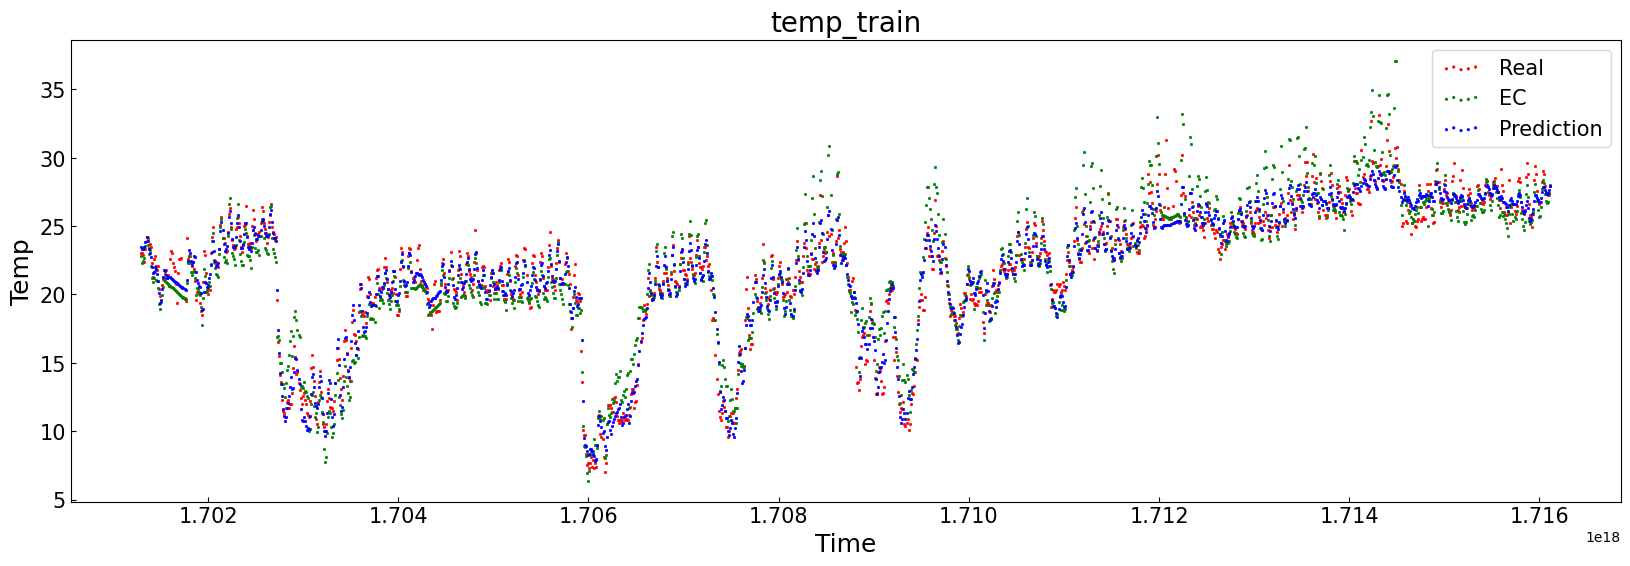

In [38]:
size = 3
line_width = 0.5
# 设置画布大小
figsize = (20, 6)
# 创建画布
plt.figure(figsize = figsize)
## 全局设置
# 绘制第一幅图
plt.scatter(time_train, train_label, s=size, linewidth=line_width, label='Real', color='red')
plt.scatter(time_train, train_feature, s=size, linewidth=line_width, label='EC', color='green')
plt.scatter(time_train, train_prediction, s=size, linewidth=line_width, label='Prediction', color='blue')

plt.tick_params(direction='in', labelsize=15)
plt.ylabel('Temp', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.title('temp_train', fontsize=20)
plt.legend(scatterpoints = 5, loc='upper right', fontsize=15)
# plt.savefig('../pic_01/风速插值前后对比图（EC）', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
## 测试集上结果
test_feature = feature_test[:, -1, 0].flatten() * (feature_max[0] - feature_min[0]) + feature_min[0]
test_prediction = model(feature_test_tensor).detach().numpy().flatten()
test_label = label_test.flatten()

In [40]:
import pandas as pd
# 将时间转为正常形式
timestamps = time_test 
datetime = pd.to_datetime(timestamps)

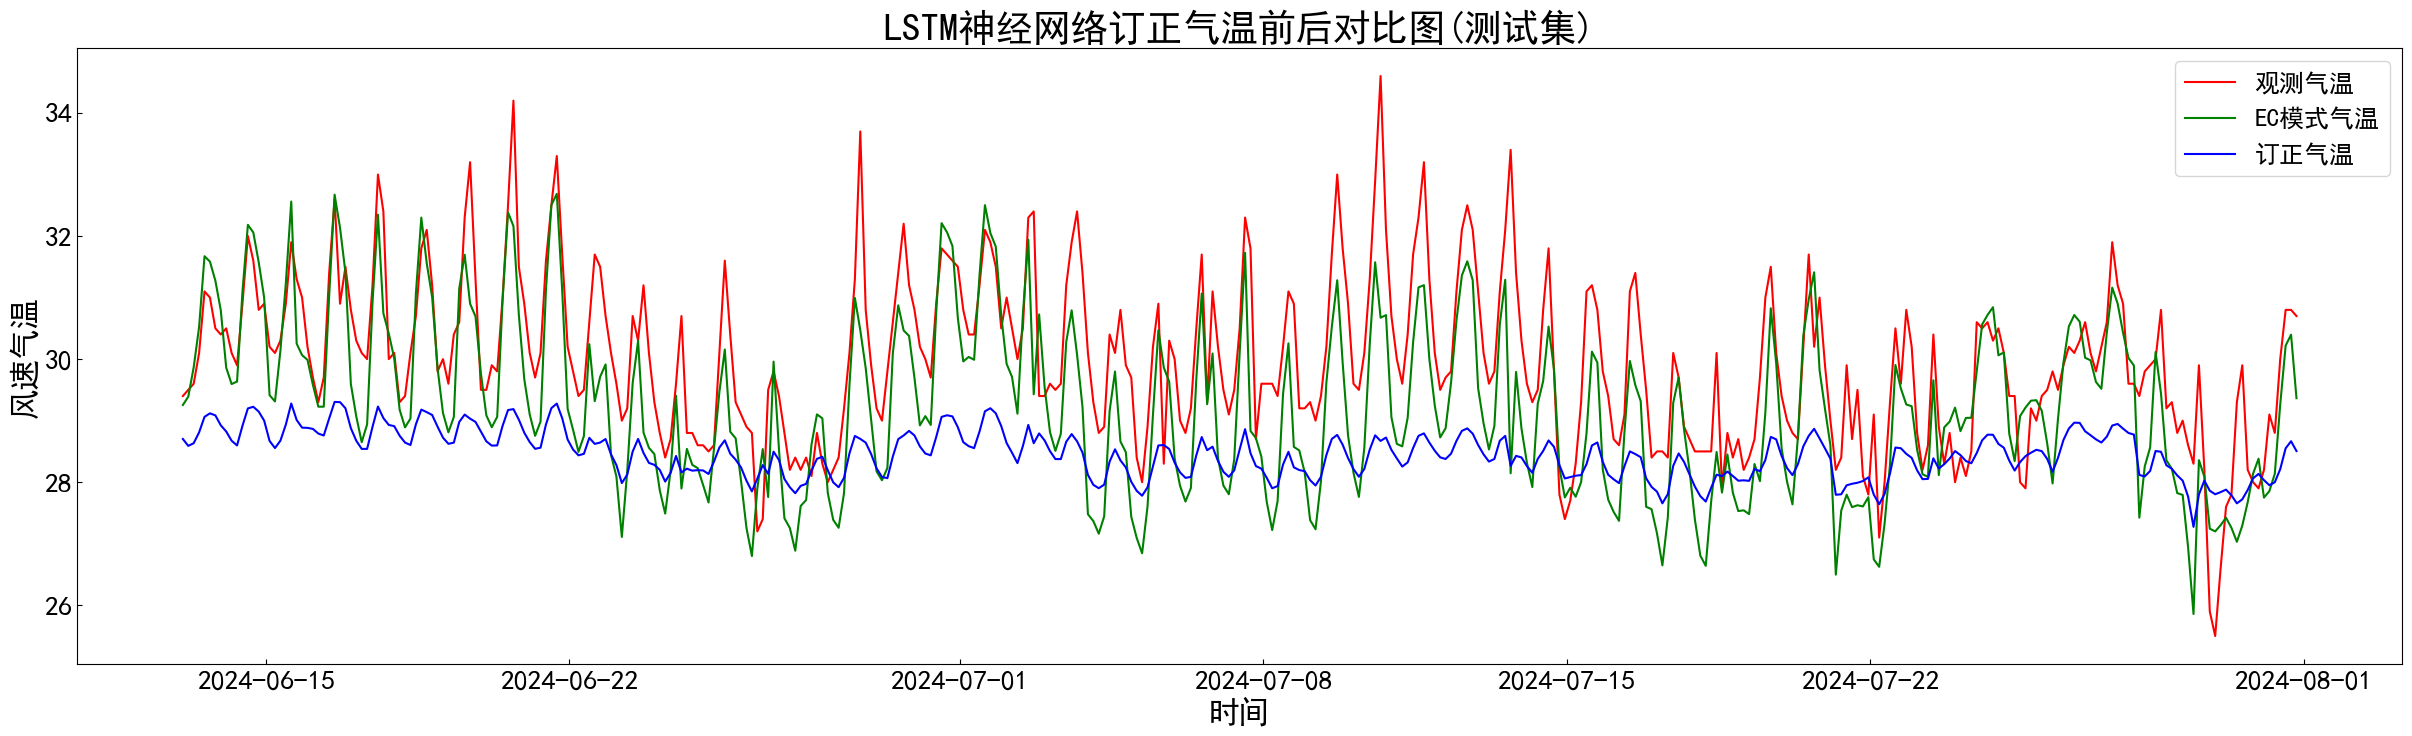

In [41]:
# 设置Matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

size = 8
line_width = 1.5

s = 0
e = -1

# 设置画布大小
figsize = (30, 8)
# 创建画布
plt.figure(figsize = figsize)
## 全局设置
# 绘制第一幅图
plt.plot(datetime[s:e], test_label[s:e], color = 'red', linewidth = line_width, label = '观测气温')
plt.plot(datetime[s:e], test_feature[s:e], color = 'green', linewidth = line_width, label = 'EC模式气温')
plt.plot(datetime[s:e], test_prediction[s:e], color = 'blue', linewidth = line_width, label = '订正气温')

plt.tick_params(direction='in', labelsize=20)
plt.ylabel('风速气温', fontsize=22)
plt.xlabel('时间', fontsize=22)
plt.legend(scatterpoints = 5, loc='upper right',fontsize=18)
plt.title('LSTM神经网络订正气温前后对比图(测试集)',fontsize=27)
plt.savefig('../pic_01/LSTM_temp_test.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
# RMSE
rmse_model = np.sqrt(np.mean((test_label - test_feature) ** 2))
rmse_prediction = np.sqrt(np.mean((test_label - test_prediction) ** 2))
rmse_diff = rmse_model - rmse_prediction
print('均方根误差', '训练前：', rmse_model, '训练后：', rmse_prediction, '误差降低：', rmse_diff)

均方根误差 训练前： 1.1619077 训练后： 1.8774263 误差降低： -0.7155186


In [43]:
# MAE
mae_model = np.mean(np.abs(test_label - test_feature))
mae_prediction = np.mean(np.abs(test_label - test_prediction))
mae_diff = mae_model - mae_prediction
print('平均绝对误差', '训练前：', mae_model, '训练后：', mae_prediction, '误差降低：', mae_diff)

平均绝对误差 训练前： 0.9408923 训练后： 1.5988926 误差降低： -0.6580003


In [44]:
# PCC
pcc_model = np.corrcoef(test_label, test_feature)[0, 1]
pcc_prediction = np.corrcoef(test_label, test_prediction)[0, 1]
pcc_diff =  pcc_prediction - pcc_model
print('皮尔逊相关系数', '训练前：', pcc_model, '训练后：', pcc_prediction, '相关增加：', pcc_diff)

皮尔逊相关系数 训练前： 0.7933817844998204 训练后： 0.7488815992894007 相关增加： -0.04450018521041976
